# Final Stage: Data Analysis

<p>As a recap, in the previous stage I trained an artificial neural network using the NEAT algorithm to play <i>Flappy Bird</i>. I wanted to train the model using two different fitness functions and compare the results of the training phases of the two. One of the models acted as a control group and its fitness score was simply determined by its lifespan (in milliseconds). The second model acted as an experimental group in which its fitness score was a function of points scored and jumps made. The fitness function for the experimental model is directly proportional to points scored and inversely proportional to jumps made, so the idea is that a high fitness score would maximize points and minimize jumps.</p>
\[f_{\text{control}} \left(b\right) = t \hspace{10mm} f_{\text{experimental}} \left(e\right) = \text{points}^{2} \cdot e^{-0.001 \cdot \text{moves}}\]
<p>In this stage, we will perform a brief exploratory data analysis to compare the results of the control group to the experimental group. Specifically, we will do the following: </p>

<ul>
    <li>Generate a curve of best fit that estimates the relationship between an independent variable, the generation, and a dependent variable, the points scored in that generation. For this, we will assume the relationship follows a sigmoid curve.</li>
    <li>Use numerical differentiation to compute where each model plateaued and its growth rate leveled off. The growth rate is defined as the derivative of points with respect to generation. We're assuming that if a model leveled of first, it was able to find an optimal set of weights faster.</li>
</ul>

## Flappy AI Control Group Data Analysis

In this section, we will perform our data analysis on the data generated by the control group.

In [19]:
import pandas
import math
import matplotlib.pyplot as plt
import numpy as np

import warnings

warnings.filterwarnings('ignore')

dataset = pandas.read_csv('control_group.csv', index_col = 0) # Import dataset for the control group.

dataset.columns = ['Points']

records = dataset.shape[0]

dataset

,Points
0,0
1,0
2,3
3,1
4,0
...,...
145,176
146,176
147,176
148,176


In [20]:
dataset.describe()

,Points
count,150.000000
mean,117.633333
std,81.253057
min,0.000000
25%,4.000000
50%,176.000000
75%,176.000000
max,176.000000


In [21]:
from scipy.optimize import curve_fit

actual_x, actual_y = list(range(records)), dataset['Points'].to_numpy()

max_score = max(actual_y)

def s(x, a, b, c, d, e): # Sigmoid function
    return (a / (1 + (b ** (-c*(x-d)))))+e

params, params_covariances = curve_fit(s, actual_x, actual_y) # Compute the coefficients of the curve of best fit.

params # Coefficients of the curve of best fit.

array([173.28904293,  11.07967596,   0.19525645,  50.30352206,
         3.0355817 ])

<p>Here we will plot the actual values scored by the control group in the training phase against the values predicted by the curve of best fit.</p>

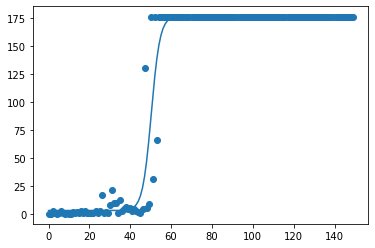

In [22]:
f = lambda x : s(x, params[0], params[1], params[2], params[3], params[4])

plt.scatter(actual_x, actual_y)
plt.plot(actual_x, f(actual_x))

In [23]:
comparison = zip(actual_y, map(f, actual_x))

comparison = pandas.DataFrame(comparison, columns = ['Actual', 'Predicted'])

comparison.describe() # Descriptory statistics for the actual scores and predicted scores.

,Actual,Predicted
count,150.000000,150.000000
mean,117.633333,117.633333
std,81.253057,79.635885
min,0.000000,3.035582
25%,4.000000,3.420292
50%,176.000000,176.322556
75%,176.000000,176.324625
max,176.000000,176.324625


In [24]:
from sklearn.metrics import mean_squared_error, r2_score

# Compute RMSE and R-Squared to evaluate the curve of best fit.

rmse = math.sqrt(mean_squared_error(actual_y, list(map(f, actual_x))))

print(f'RMSE: {round(rmse, 3)} points')
print(f'R-Squared: {round(100 * r2_score(actual_y, list(map(f, actual_x))), 3)}%')

RMSE: 16.076 points
R-Squared: 96.059%


<p>Here we will attempt to find where the growth rate of the control group reached a plateau. The cutoff for the plateau point $g$ is that the group scored the maximum number of points and $\frac{\partial P}{\partial g} < \frac{1}{10}$. To compute the rates of change, we will a function for numerical differentiation from the SciPy library.

In [25]:
from scipy.misc import derivative

plateau, found = 0, False

while plateau < records:
    if derivative(f, plateau) < math.pow(10, -1) and actual_y[plateau] == max_score:
        found = True
        break
    plateau += 1

if found:
    print(f'The growth rate leveled off at: Generation {plateau}')
else:
    print(f'The growth rate did not level off during the training phase.')

The growth rate leveled off at: Generation 65


## Flappy AI Experimental Group Data Analysis

In [26]:
dataset = pandas.read_csv('experimental_group.csv', index_col = 0) # Import dataset for the experimental group.

dataset.columns = ['Points']

records = dataset.shape[0]

dataset

,Points
0,1
1,4
2,1
3,1
4,1
...,...
145,176
146,176
147,176
148,176


In [27]:
dataset.describe()

,Points
count,150.000000
mean,120.013333
std,77.723740
min,0.000000
25%,12.000000
50%,176.000000
75%,176.000000
max,176.000000


In [28]:
actual_x, actual_y = list(range(records)), dataset['Points'].to_numpy()

params, params_covariances = curve_fit(s, actual_x, actual_y) # Compute the coefficients of the curve of best fit.

params # Coefficients of the curve of best fit

array([1.66648030e+02, 2.84598626e+00, 1.51418292e-01, 5.14149327e+01,
       1.10439924e+01])

<p>Here we will plot the actual values scored by the control group in the training phase against the values predicted by the curve of best fit.</p>

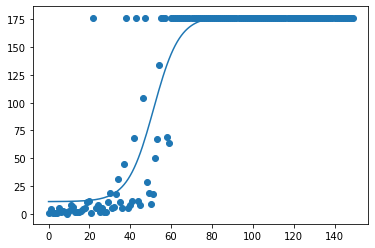

In [29]:
f = lambda x : s(x, params[0], params[1], params[2], params[3], params[4])

plt.scatter(actual_x, actual_y)
plt.plot(actual_x, f(actual_x))

In [30]:
comparison = zip(actual_y, map(f, actual_x))

comparison = pandas.DataFrame(comparison, columns = ['Actual', 'Predicted'])

comparison.describe() # Descriptory statistics for the actual scores and predicted scores.

,Actual,Predicted
count,150.000000,150.000000
mean,120.013333,120.013332
std,77.723740,71.769088
min,0.000000,11.092454
25%,12.000000,27.058281
50%,176.000000,173.482723
75%,176.000000,177.680192
max,176.000000,177.691990


In [31]:
# Compute RMSE and R-Squared to evaluate the curve of best fit.

rmse = math.sqrt(mean_squared_error(actual_y, list(map(f, actual_x))))

print(f'RMSE: {round(rmse, 3)} points')
print(f'R-Squared: {round(100 * r2_score(actual_y, list(map(f, actual_x))), 3)}%')

RMSE: 29.735 points
R-Squared: 85.265%


<p>Here we will attempt to find where the growth rate of the experimental group reached a plateau, using the same constraints as the control group.</p> 

In [33]:
plateau, found = 0, False

while plateau < records:
    if derivative(f, plateau) < math.pow(10, -1) and actual_y[plateau] == max_score:
        found = True
        break
    plateau += 1

if found:
    print(f'The growth rate plateaued at: Generation {plateau}')
else:
    print(f'The growth rate did not plateau during the training phase.')

The growth rate plateaued at: Generation 87


## Interpretation

<ul>
    <li>The growth rate for the control group reached a plateau at Generation 65, while the experimental group reached a plateau at Generation 87. For this reason, we can infer that the control model, with a linear fitness function, was able to generalize the environment faster than the experimental model, which had a nonlinear fitness function.</li>
    <li>The curve of best fit for the control group scored a RMSE of 16.076 points. This means that roughly ninety-five percent of the data-points lied within 32.152 points of the curve of best fit for the control group. The curve of best fit for the experimental group scored a RMSE of 29.735 points, meaning that roughly ninety-five percent of the data-points lied within 59.47 points of the curve of best fit for the experimental group. The lower variance between the actual and predicted values attained by the control group suggests that it was easier to generalize the relationship between generation and points using a curve of best fit. In addition, this suggests that the control group trained more consistently than the experimental group, which is also supported the higher number of outliers in the experimental group. For example, at Generation 22, the experimental group reached the point cutoff of one hundred seventy-five, however in Generation 23, it dropped back down to five points, suggesting a more chaotic training phase.</li>
</ul>

## Conclusion

<ul>
    <li>The results of the data analysis suggests that the control model was able to generalize the environment faster than the experimental model.</li>
    <li>The results also suggest that the control group improved more consistently than the experimental group, suggested by the lower variance between predicted and actual values between the dataset and its curve of best fit.</li>
    <li>There is evidence to suggest that a simpler, linear fitness function is better suited to training the model than the fitness function of the experimental model, which was intended to maximize score and minimize jumps made.</li>
</ul>